EMOTIONAL ANALYSIS:




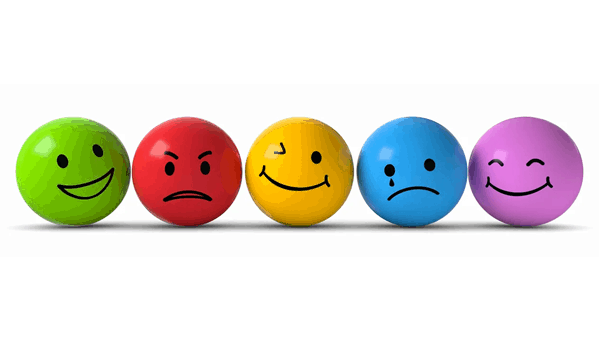

Emotion analysis is the process of identifying and analyzing the underlying emotions expressed in textual data.. Emotion analytics can extract the text data from multiple sources to analyze the subjective information and understand the emotions behind. Emotion analysis is focus on targeting to automatically extract the emotional states of users from their reviews (e.g., blogs, tweets, post, etc.) in social networks.

Workflow:
1.Import Data
2.prepare the input data
3.Import pre-trained W2V
4.Create Neural Network Pipeline
5.Train The Model
6.Evaluate results

IMPORTING DATA FROM GITHUB

In [ ]:
!git clone https://github.com/foxed838/emotion_model

Cloning into 'emotion_model'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


REQUIRED LIBRARIES 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

READING DATA

In [ ]:
data_train = pd.read_csv('/content/emotion_model/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/emotion_model/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

exploratory data analysis|

In [ ]:
data.columns

Index(['Emotion', 'Text'], dtype='object')

In [ ]:
data.shape

(11327, 2)

In [ ]:
data.head()

,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


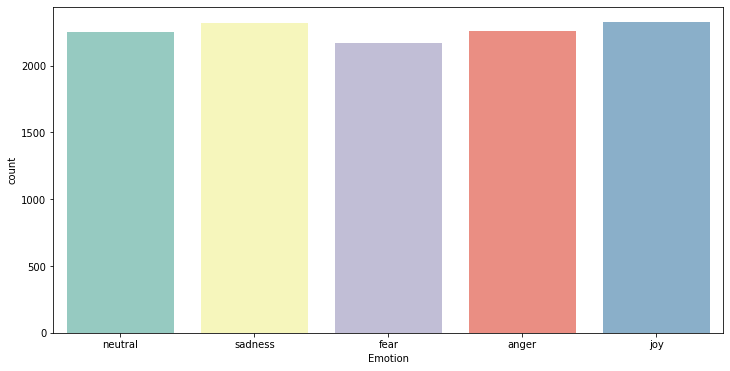

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,6))
sns.countplot(data["Emotion"], palette='Set3')

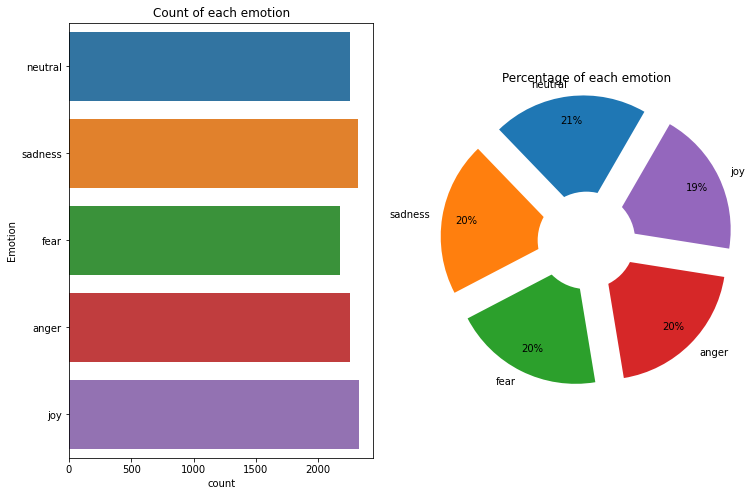

In [ ]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(data["Emotion"].dropna().value_counts()))/sum(list(data["Emotion"].dropna().value_counts())))[::-1])[:]
labels = list(data["Emotion"].dropna().unique())[:]
sizes = data["Emotion"].value_counts()[:]

ax2.pie(sizes,  explode=explode, startangle=60, labels=labels, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y="Emotion", data= data, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

In [ ]:
!pip install WordCloud


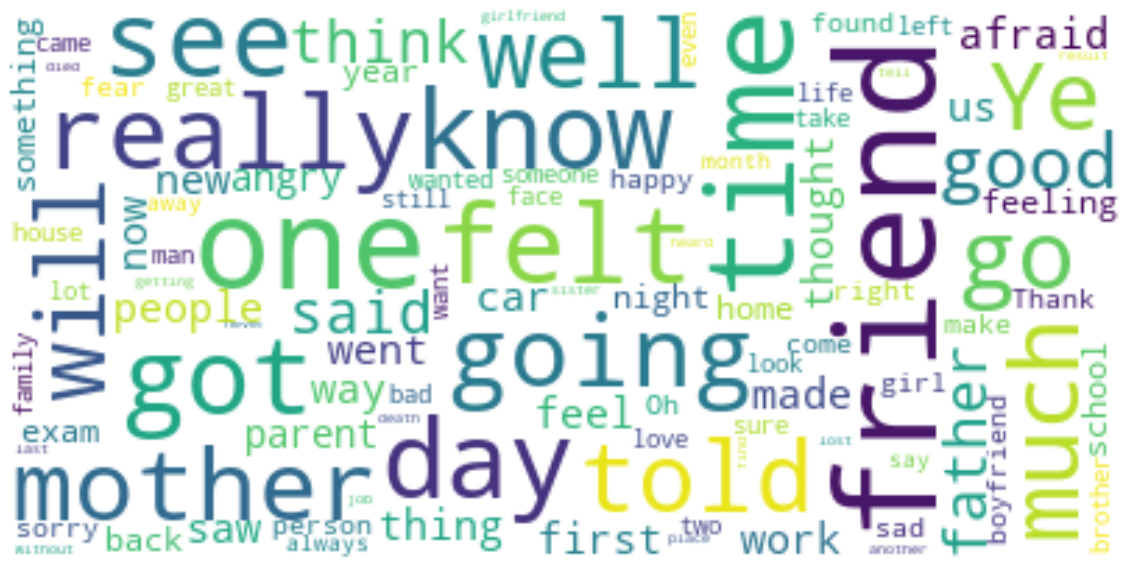

In [ ]:
from wordcloud import WordCloud

text = " ".join(cat for cat in data["Text"])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Prepare input data


To input the data to our NN Model we'll need some preprocessing:

Tokenize our texts and count unique tokens
Padding: each input (sentence or text) has to be of the same lenght
Labels have to be converted to integeres and categorized
Basic preprocessing and tokenization using nltk. We could also add stopword removal but steps like stemming or lemmatization are not needed since we are using word2vec and words with the same stem can have a different meaning.

In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

Number of unique words: 12088


array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

**Import pretrained word vectors**


Importing pretrained word2vec from file and creating embedding matrix
We will later map each word in our corpus to existing word vector

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, 'r', errors = 'ignore', encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'


if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

**Embedding Layer**


We will use pre-trained word vectors. We could also train our own embedding layer if we don't specify the pre-trained weights

In [ ]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

**Model Pipeline:**


The input is the first N words of each text (with proper padding)
the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
LSTM/GRU layer which will receive word embeddings for each token in the tweet as inputs. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens; In other words, the LSTM layer is generating a new encoding for the original input.
the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function
You can change GRU to LSTM. The results will be very similar but LSTM might take longer to train.

In [ ]:
# Parameters
gru_output_size = 64
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626700   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              140544    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 3,767,889
Trainable params: 141,189
Non-trainable params: 3,626,700
_________________________________________________________________


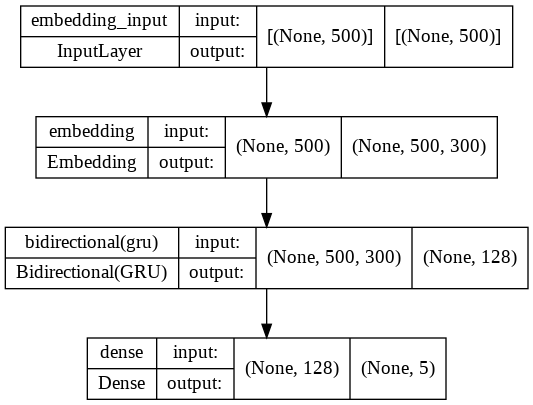

In [ ]:
tf.keras.utils.plot_model(model, to_file="my_model.png", show_shapes=True)

Train the Model

In [ ]:
batch_size = 128
epochs = 12

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/12
62/62 [==============================] - 397s 6s/step - loss: 1.4770 - accuracy: 0.3571 - val_loss: 1.3307 - val_accuracy: 0.4400
Epoch 2/12
62/62 [==============================] - 390s 6s/step - loss: 1.2275 - accuracy: 0.5000 - val_loss: 1.1320 - val_accuracy: 0.5511
Epoch 3/12
62/62 [==============================] - 391s 6s/step - loss: 1.0278 - accuracy: 0.6075 - val_loss: 0.9422 - val_accuracy: 0.6466
Epoch 4/12
62/62 [==============================] - 387s 6s/step - loss: 0.8569 - accuracy: 0.6865 - val_loss: 0.8332 - val_accuracy: 0.6905
Epoch 5/12
62/62 [==============================] - 387s 6s/step - loss: 0.7788 - accuracy: 0.7153 - val_loss: 0.8103 - val_accuracy: 0.7073
Epoch 6/12
62/62 [==============================] - 377s 6s/step - loss: 0.7495 - accuracy: 0.7255 - val_loss: 0.7929 - val_accuracy: 0.7056
Epoch 7/12
62/62 [==============================] - 393s 6s/step - loss: 0.7163 - accuracy: 0.7409 - val_loss: 0.7621 - val_accuracy: 0.7250
Epoch 8/12
62

Evaluation

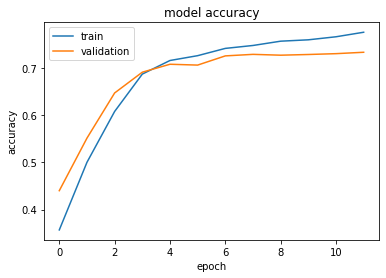

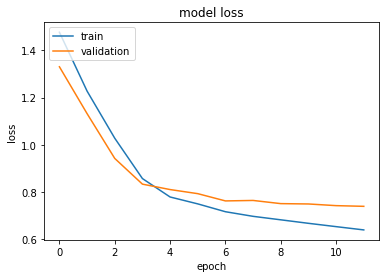

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#"Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 73.27%

F1 Score: 73.27


PREDICTING DATA SAMPLES 

In [ ]:
import time
def review(message):
  seq = tokenizer.texts_to_sequences(message)
  padded = pad_sequences(seq, maxlen=max_seq_len)

  start_time = time.time()
  pred = model.predict(padded)

  print('Message: ' + str(message))
  print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))


In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [ ]:
mes = ['There was a hairline scratch on the screen which is not clearly visible directly. When we tried contacting Amazon for the replacement, they asked us to connect to apple and when connected to apple, they asked to connect with Amazon. Blame game begins and we end up paying the price. Awfull service. I am going to tag on the social media both Amazon and apple. Such a big scam']

In [ ]:
review(mes)

Message: ['There was a hairline scratch on the screen which is not clearly visible directly. When we tried contacting Amazon for the replacement, they asked us to connect to apple and when connected to apple, they asked to connect with Amazon. Blame game begins and we end up paying the price. Awfull service. I am going to tag on the social media both Amazon and apple. Such a big scam']
predicted: anger (0.44 seconds)


In [ ]:
message1 = ['i am poor and i cant afford it lmao xdxdxdxdxd so if you have money to flex buy it i am bored thats why i am writing this review while drinking coffee i have my chemistry exam on manday and cant study mole concept and got bored thats why i came here to write this review if you read this review til here very good you justt wasted your time now go and do something productive :)']

In [ ]:
review(message1)

Message: ['i am poor and i cant afford it lmao xdxdxdxdxd so if you have money to flex buy it i am bored thats why i am writing this review while drinking coffee i have my chemistry exam on manday and cant study mole concept and got bored thats why i came here to write this review if you read this review til here very good you justt wasted your time now go and do something productive :)']
predicted: sadness (0.71 seconds)


In [ ]:
message_3 = ['Same as I phone 12 😑. Who so ever is reading this review I suggest go for I phone 12'] 
review(message_3)

Message: ['Same as I phone 12 😑. Who so ever is reading this review I suggest go for I phone 12']
predicted: neutral (1.02 seconds)
